In [ ]:
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import os
import glob

# Hardcoded color scale range (in kWh per 3h)
VMIN = 0
VMAX = 6000

def process_file(file_path):
    """
    Process a single NetCDF file containing wind data and generate wind energy analysis plots.
    
    Args:
        file_path (str): Path to the NetCDF file
    """
    # Load the dataset
    ds = xr.open_dataset(file_path)
    
    # Extract wind speed (in m/s)
    u10 = ds["sfcWind"]  # [time, lat, lon]

    # Adjust to hub height (~100m)
    def adjust_height(u_10, z1=10, z2=100, alpha=0.143):
        return u_10 * (z2 / z1) ** alpha

    u_hub = adjust_height(u10)

    # Define power curve function (Vestas V110-2.0MW)
    def turbine_power(v):
        rated = 2000  # kW
        if isinstance(v, xr.DataArray):
            p = xr.zeros_like(v)
            p = xr.where((v >= 3) & (v < 12), rated * ((v - 3) / 9) ** 3, p)
            p = xr.where((v >= 12) & (v <= 25), rated, p)
            return p
        else:
            if v < 3 or v > 25:
                return 0
            elif v <= 12:
                return rated * ((v - 3) / 9) ** 3
            else:
                return rated

    # Apply power curve
    power_output = turbine_power(u_hub)  # [time, lat, lon], in kW

    # Convert to energy (kWh) per 3h timestep
    energy_kwh = power_output * 3  # [time, lat, lon]

    # Average over time
    energy_avg = energy_kwh.mean(dim="time")  # [lat, lon]

    # Create output directory if it doesn't exist
    output_dir = "output"
    os.makedirs(output_dir, exist_ok=True)

    # Extract year from filename (e.g., from "..._202601010100-202612302200.nc")
    filename = os.path.basename(file_path)
    # Find the timestamp part (e.g., "202601010100-202612302200")
    timestamp_part = filename.split('_')[-1].split('.')[0]
    # Extract the year (first 4 digits of the timestamp)
    year = timestamp_part[:4]

    # Generate filenames with year
    display_path = os.path.join(output_dir, f"display_wind_{year}.png")
    export_path = os.path.join(output_dir, f"export_wind_{year}.png")

    # Create display plot (with proper formatting)
    fig_display = plt.figure(figsize=(10, 8))
    ax_display = plt.axes(projection=ccrs.PlateCarree())
    energy_avg.plot(
        ax=ax_display,
        x='lon',
        y='lat',
        vmin=VMIN,
        vmax=VMAX,
        transform=ccrs.PlateCarree(),
        cmap="viridis",
        cbar_kwargs={'label': 'Avg Wind Energy (kWh per 3h)'}
    )
    ax_display.coastlines()
    ax_display.add_feature(cfeature.BORDERS)
    ax_display.set_extent([-85, -30, -55, 15])  # Zoom on Latin America
    ax_display.set_title(f"Wind Energy Potential (3h Avg, kWh) – Vestas V110 - {year}")
    plt.tight_layout()
    plt.show()
    
    # Save display plot
    plt.savefig(display_path, dpi=300)
    plt.close(fig_display)

    # Create export plot (clean, without borders)
    fig_export = plt.figure(figsize=(40, 40))
    ax_export = plt.axes(projection=ccrs.epsg('3857'))
    ax_export.set_global()
    ax_export.set_position([0, 0, 1, 1])
    plt.margins(0, 0)
    plt.subplots_adjust(left=0, right=1, bottom=0, top=1, wspace=0, hspace=0)
    plt.xlabel('')
    plt.ylabel('')
    ax_export.axis('off')
    ax_export.set_frame_on(False)
    
    energy_avg.plot(
        ax=ax_export,
        x='lon',
        y='lat',
        vmin=VMIN,
        vmax=VMAX,
        transform=ccrs.PlateCarree(),
        cmap="viridis",
        add_colorbar=False,
    )
    
    plt.show()
    
    # Save export plot
    plt.savefig(export_path,
                bbox_inches=None,
                pad_inches=0,
                transparent=True,
                dpi=600)
    plt.close(fig_export)
    
    print(f"Processed {file_path} and saved plots to:")
    print(f"- Display plot: {display_path}")
    print(f"- Export plot: {export_path}")

# Process all files in data directory
data_dir = "data"
for file_path in glob.glob(os.path.join(data_dir, "*.nc")):
    print(f"Processing {file_path}")
    process_file(file_path)



Step-by-Step Plan

1. Choose a representative wind turbine
Let’s use a model like the Vestas V110-2.0 MW, a popular choice in Latin America: bold text

Rated power: 2.0 MW

Cut-in wind speed: ~3 m/s

Rated wind speed: ~11–12 m/s

Cut-out wind speed: ~25 m/s

Hub height: 80–100 m

We'll adjust the 10 m wind speeds to hub height with a logarithmic or power-law wind profile (unless your CORDEX data already gives wind at hub height).



**2. Convert wind speed at 10 m to hub height (~100 m)**
Using a power-law profile (α = 0.143 for neutral conditions)

In [ ]:
def adjust_height(u_10, z1=10, z2=100, alpha=0.143):
    return u_10 * (z2 / z1) ** alpha

**3. Apply the power curve of the turbine**
We'll use a simplified version of the V110-2.0 MW turbine power curve

In [ ]:
def turbine_power(v):
    if v < 3 or v > 25:
        return 0
    elif v <= 12:
        return 2000 * ((v - 3) / (12 - 3)) ** 3  # Cubic approximation
    else:
        return 2000  # Rated power (kW)

## **4. Compute energy over 3-hour intervals**

In [ ]:
energy_kwh = power_kw * 3  # Because each timestep is 3 hours

**5. Ploting the results**

In [ ]:
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Load your dataset
ds = xr.open_dataset("your_file.nc")

# Extract wind speed (in m/s)
u10 = ds["sfcWind"]  # [time, lat, lon]

# Adjust to hub height (~100m)
def adjust_height(u_10, z1=10, z2=100, alpha=0.143):
    return u_10 * (z2 / z1) ** alpha

u_hub = adjust_height(u10)

# Define power curve function (Vestas V110-2.0MW)
def turbine_power(v):
    rated = 2000  # kW
    if isinstance(v, xr.DataArray):
        p = xr.zeros_like(v)
        p = xr.where((v >= 3) & (v < 12), rated * ((v - 3) / 9) ** 3, p)
        p = xr.where((v >= 12) & (v <= 25), rated, p)
        return p
    else:
        if v < 3 or v > 25:
            return 0
        elif v <= 12:
            return rated * ((v - 3) / 9) ** 3
        else:
            return rated

# Apply power curve
power_output = turbine_power(u_hub)  # [time, lat, lon], in kW

# Convert to energy (kWh) per 3h timestep
energy_kwh = power_output * 3  # [time, lat, lon]

# Average over time (optional)
energy_avg = energy_kwh.mean(dim="time")  # [lat, lon]

# Plotting
fig = plt.figure(figsize=(10, 8))
ax = plt.axes(projection=ccrs.PlateCarree())
energy_avg.plot(
    ax=ax,
    transform=ccrs.PlateCarree(),
    cmap="viridis",
    cbar_kwargs={'label': 'Avg Wind Energy (kWh per 3h)'}
)
ax.coastlines()
ax.add_feature(cfeature.BORDERS)
ax.set_extent([-85, -30, -55, 15])  # Zoom on Latin America
ax.set_title("Wind Energy Potential (3h Avg, kWh) – Vestas V110")
plt.tight_layout()
plt.show()


From here to below is my old code in case you want to check what I did before.

In [ ]:
from __future__ import division
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LATITUDE_FORMATTER, LONGITUDE_FORMATTER
import warnings
warnings.simplefilter('ignore')
%matplotlib inline

In [ ]:
files = ['add hear files names I sent to you']

In [ ]:
prefix = "C:/Users/Natalia/Desktop/Doutorado/@_Tese/Chapters/Data/Cordex/sfcwind_85/" #add the path to the datasets
path = [prefix+file for file in files]
path

['C:/Users/Natalia/Desktop/Doutorado/@_Tese/Chapters/Data/Cordex/sfcwind_85/sfcWind_SAM-44i_MOHC-HadGEM2-ES_historical_r1i1p1_SMHI-RCA4_v3_mon_196101-197012.nc',
 'C:/Users/Natalia/Desktop/Doutorado/@_Tese/Chapters/Data/Cordex/sfcwind_85/sfcWind_SAM-44i_MOHC-HadGEM2-ES_historical_r1i1p1_SMHI-RCA4_v3_mon_197101-198012.nc',
 'C:/Users/Natalia/Desktop/Doutorado/@_Tese/Chapters/Data/Cordex/sfcwind_85/sfcWind_SAM-44i_MOHC-HadGEM2-ES_historical_r1i1p1_SMHI-RCA4_v3_mon_198101-199012.nc',
 'C:/Users/Natalia/Desktop/Doutorado/@_Tese/Chapters/Data/Cordex/sfcwind_85/sfcWind_SAM-44i_MOHC-HadGEM2-ES_historical_r1i1p1_SMHI-RCA4_v3_mon_199101-200012.nc',
 'C:/Users/Natalia/Desktop/Doutorado/@_Tese/Chapters/Data/Cordex/sfcwind_85/sfcWind_SAM-44i_MOHC-HadGEM2-ES_historical_r1i1p1_SMHI-RCA4_v3_mon_200101-200512.nc',
 'C:/Users/Natalia/Desktop/Doutorado/@_Tese/Chapters/Data/Cordex/sfcwind_85/sfcWind_SAM-44i_MOHC-HadGEM2-ES_rcp85_r1i1p1_SMHI-RCA4_v3_mon_200601-201012.nc',
 'C:/Users/Natalia/Desktop/Doutor

In [ ]:
ds = xr.open_mfdataset(path)
w = ds['sfcWind']

In [ ]:
w_vel =  w * 10**0.2
w_vel_l = w_vel.where(w>3).where(w<25)
w_power = (0.5 * 0.95 * 7864 * 0.593 * 1.225 * w_vel_l**3)*1000 #Watt
w_season = w_power /1000000.0   #to transform in MW
w_anual = w_power /1000000.0  #to transform in MW

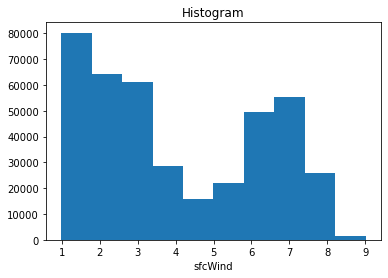

In [ ]:
hist_anual = w.sel(time=slice('1961-01','2005-12'))
hist_w_anual = hist_anual.sel(lon=slice(-80, -30), lat=slice(-35, 10)).groupby('time.year').mean(dim='time').plot()

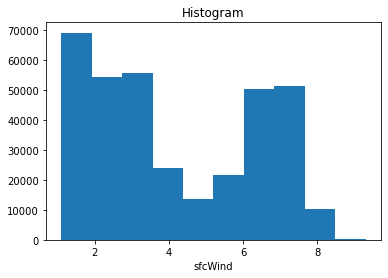

In [ ]:
w_yearly = w.sel(time=slice('2061-01','2099-12')).sel(lon=slice(-80, -30), lat=slice(-35, 10)).groupby('time.year').mean(dim='time').plot()

# mean historical wind power density MW

In [ ]:
y_hist = w_anual.sel(time=slice('1971-01','2000-12')).mean(dim='time')

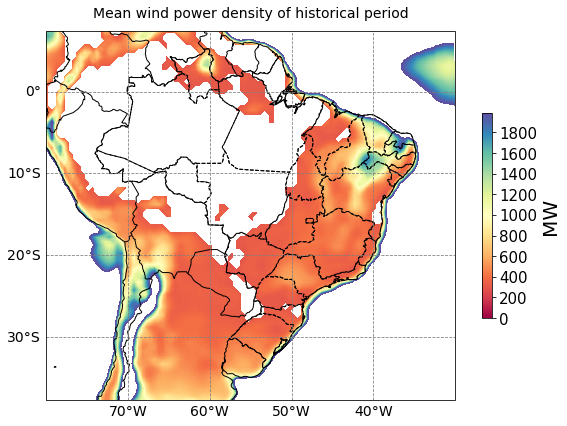

In [ ]:
#Criando um objeto de figura para receber o mapa
fig = plt.figure(figsize=(8, 8))

#Criando um eixo com uma determinada projeção
ax = fig.add_subplot(111, projection=ccrs.PlateCarree())

#Definindo a extensão do mapa
ax.set_extent([-80, -30, -35, 7])

#Criando matrizes de longitude e latitude
lon, lat = np.meshgrid(y_hist.lon, y_hist.lat)

#Plotando a temperatura do ar para o globo todo
im = ax.contourf(lon, lat, y_hist, cmap='Spectral', levels=np.arange(0, 2000, 10), transform=ccrs.PlateCarree())


#Inserindo uma colorbar
cbar = fig.colorbar(im, ax=ax, pad=0.06, fraction=0.023)
cbar.set_label(label='MW', size=20, weight='normal')
cbar.ax.tick_params(labelsize=15)

#Adicionando o contorno dos continentes
ax.add_feature(cfeature.COASTLINE)

#Adicionando os limites dos países
ax.add_feature(cfeature.BORDERS)

#Adicionando os limites estaduais
states = cfeature.NaturalEarthFeature(category='cultural',
                                      name='admin_1_states_provinces_shp',
                                      scale='50m',
                                      facecolor='none')
ax.add_feature(states, edgecolor='k', linestyle='--')

#Adicionando o título da figura
ax.set_title('Mean wind power density of historical period', fontsize=14, y=1.02)

#Adicionando as linhas de grade
g1 = ax.gridlines(crs=ccrs.PlateCarree(), linestyle='--', color='gray', draw_labels=True)

#Removendo os labels do topo e da direita
g1.ylabels_right = False
g1.xlabels_top = False

#Formatando os labels como latitude e longitude
g1.yformatter = LATITUDE_FORMATTER
g1.xformatter = LONGITUDE_FORMATTER

#Mofificando o tamanho da fonte dos labels
g1.xlabel_style = {'size': 14}
g1.ylabel_style = {'size': 14}

plt.savefig('RV_26_1.png', dpi=300, bbox_inches='tight')

# Variability

In [ ]:
iav = w_anual.sel(time=slice('2006-01','2099-12')) - y_hist
BR = iav.sel(time=slice('2006-01',None)).resample(time='Y').mean(dim='time')
ne = iav.sel(time=slice('2006-01',None)).resample(time='Y').mean(dim='time')
s = iav.sel(time=slice('2006-01',None)).resample(time='Y').mean(dim='time')

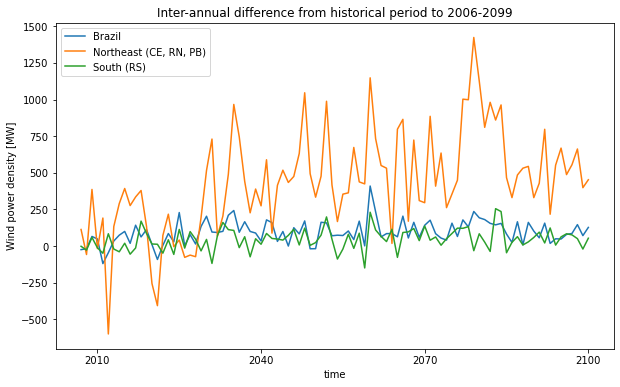

In [ ]:
axes = plt.axes()
axes.figure.set_size_inches(10, 6)
BR.sel(lon=slice(-75, -30), lat=slice(-35, 7)).mean(dim=('lat','lon')).plot(ax=axes, label='Brazil')
ne.sel(lon=slice(-40., -35.), lat=slice(-8., -2.)).mean(dim=('lat','lon')).plot(ax=axes, label='Northeast (CE, RN, PB)')
s.sel(lon=slice(-57., -49.), lat=slice(-33., -27.)).mean(dim=('lat','lon')).plot(ax=axes, label='South (RS)')
plt.ylabel("Wind power density [MW]")
plt.title('Inter-annual difference from historical period to 2006-2099')
plt.legend()

In [ ]:
w_x = w_anual
mean_x = w_x.resample(time='Y').mean(dim='time')
std_x = w_x.resample(time='Y').std(dim='time')
iav_x = std_x / mean_x
BR_x = iav_x
ne_x = iav_x
s_x = iav_x

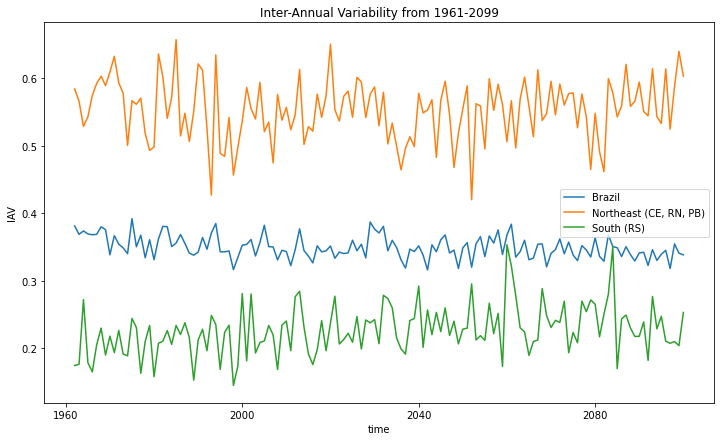

In [ ]:
axes = plt.axes()
axes.figure.set_size_inches(12, 7)
BR_x.sel(lon=slice(-75, -30), lat=slice(-35, 7)).mean(dim=('lat','lon')).plot(ax=axes, label='Brazil')
ne_x.sel(lon=slice(-40., -35.), lat=slice(-8., -2.)).mean(dim=('lat','lon')).plot(ax=axes, label='Northeast (CE, RN, PB)')
s_x.sel(lon=slice(-57., -49.), lat=slice(-33., -27.)).mean(dim=('lat','lon')).plot(ax=axes, label='South (RS)')
plt.ylabel("IAV")
plt.title('Inter-Annual Variability from 1961-2099')
plt.legend(loc='best')

In [ ]:
hist_y = w_anual.sel(time=slice('1961','2000'))
mean_y= hist_y.mean(dim='time')
std_y= w_anual.sel(time=slice('2006-01',None)).resample(time='Y').std(dim='time')
iav_y= std_y/ mean_y
BR_y= iav_y
ne_y= iav_y
s_y= iav_y

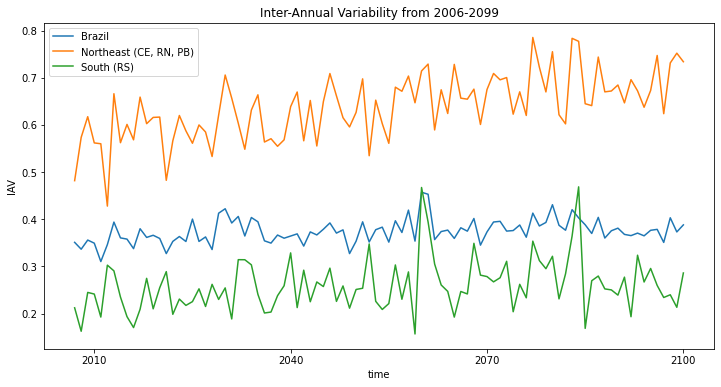

In [ ]:
axes = plt.axes()
axes.figure.set_size_inches(12, 6)
BR_y.sel(lon=slice(-75, -30), lat=slice(-35, 7)).mean(dim=('lat','lon')).plot(ax=axes, label='Brazil')
ne_y.sel(lon=slice(-40., -35.), lat=slice(-8., -2.)).mean(dim=('lat','lon')).plot(ax=axes, label='Northeast (CE, RN, PB)')
s_y.sel(lon=slice(-57., -49.), lat=slice(-33., -27.)).mean(dim=('lat','lon')).plot(ax=axes, label='South (RS)')
plt.ylabel("IAV")
plt.title('Inter-Annual Variability from 2006-2099')
plt.legend(loc='best')

# Long-term variability

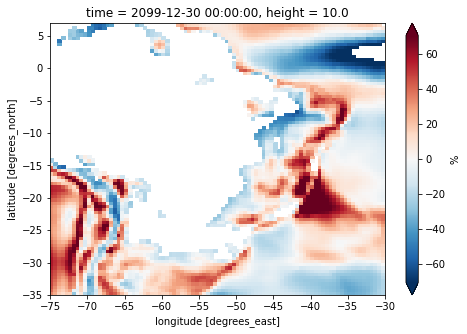

In [ ]:
lt_x = w_anual.sel(time='2099-11').resample(time='Y').mean(dim='time')
lt_y = w_anual.sel(time=slice('1971-01','1999-12')).mean(dim='time')
ltv =  ((lt_x-lt_y)/lt_y)*100
ltv.sel(lon=slice(-75, -30), lat=slice(-35, 7)).plot(cbar_kwargs={"label": "%"}, robust=True, size = 5, extend='both')

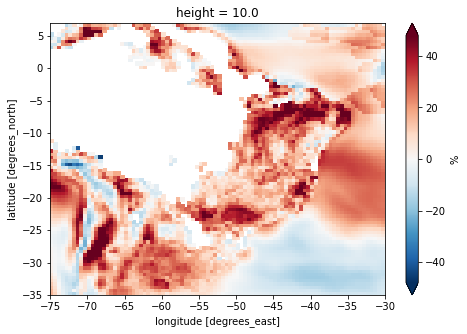

In [ ]:
lt_x = w_anual.sel(time='2099').mean(dim='time')
lt_y = w_anual.sel(time=slice('1971-01','1999-12')).mean(dim='time')
ltv =  ((lt_x-lt_y)/lt_y)*100
ltv.sel(lon=slice(-75, -30), lat=slice(-35, 7)).plot(cbar_kwargs={"label": "%"}, robust=True, size = 5, extend='both')

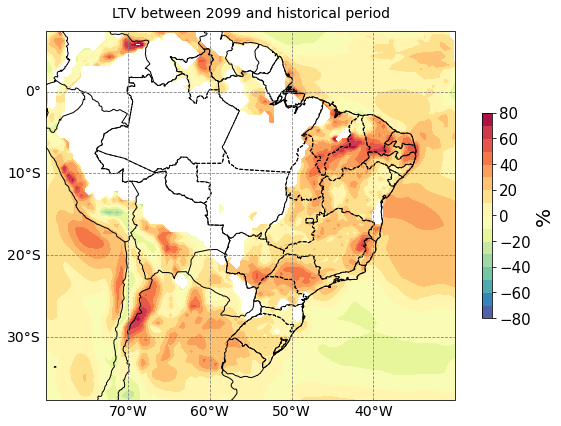

In [ ]:
#Criando um objeto de figura para receber o mapa
fig = plt.figure(figsize=(8, 8))

#Criando um eixo com uma determinada projeção
ax = fig.add_subplot(111, projection=ccrs.PlateCarree())

#Definindo a extensão do mapa
ax.set_extent([-80, -30, -35, 7])

#Criando matrizes de longitude e latitude
lon, lat = np.meshgrid(ltv.lon, ltv.lat)

#Plotando a temperatura do ar para o globo todo
im = ax.contourf(lon, lat, ltv, cmap='Spectral_r', levels=np.arange(-80, 90, 10), transform=ccrs.PlateCarree())


#Inserindo uma colorbar
cbar = fig.colorbar(im, ax=ax, pad=0.06, fraction=0.023)
cbar.set_label(label='%', size=20, weight='normal')
cbar.ax.tick_params(labelsize=15)

#Adicionando o contorno dos continentes
ax.add_feature(cfeature.COASTLINE)

#Adicionando os limites dos países
ax.add_feature(cfeature.BORDERS)

#Adicionando os limites estaduais
states = cfeature.NaturalEarthFeature(category='cultural',
                                      name='admin_1_states_provinces_shp',
                                      scale='50m',
                                      facecolor='none')
ax.add_feature(states, edgecolor='k', linestyle='--')

#Adicionando o título da figura
ax.set_title('LTV between 2099 and historical period', fontsize=14, y=1.02)

#Adicionando as linhas de grade
g1 = ax.gridlines(crs=ccrs.PlateCarree(), linestyle='--', color='gray', draw_labels=True)

#Removendo os labels do topo e da direita
g1.ylabels_right = False
g1.xlabels_top = False

#Formatando os labels como latitude e longitude
g1.yformatter = LATITUDE_FORMATTER
g1.xformatter = LONGITUDE_FORMATTER

#Mofificando o tamanho da fonte dos labels
g1.xlabel_style = {'size': 14}
g1.ylabel_style = {'size': 14}

# plot anual relative difference

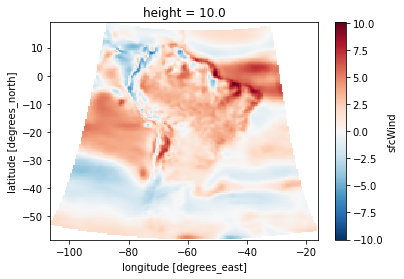

In [ ]:
#wind
x = w.sel(time=slice('2071-01','2099-12')).mean(dim='time')
y = w.sel(time=slice('1971-01','1999-12')).mean(dim='time')
div =  ((x-y)/y)*100
div.plot()

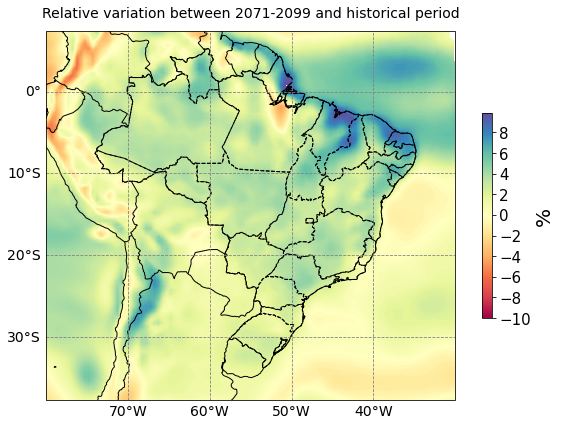

In [ ]:
#Criando um objeto de figura para receber o mapa
fig = plt.figure(figsize=(8, 8))

#Criando um eixo com uma determinada projeção
ax = fig.add_subplot(111, projection=ccrs.PlateCarree())

#Definindo a extensão do mapa
ax.set_extent([-80, -30, -35, 7])

#Criando matrizes de longitude e latitude
lon, lat = np.meshgrid(div.lon, div.lat)

#Plotando a temperatura do ar para o globo todo
im = ax.contourf(lon, lat, div, cmap='Spectral', levels=np.arange(-10, 10, 0.1), transform=ccrs.PlateCarree())


#Inserindo uma colorbar
cbar = fig.colorbar(im, ax=ax, pad=0.06, fraction=0.023)
cbar.set_label(label='%', size=20, weight='normal')
cbar.ax.tick_params(labelsize=15)

#Adicionando o contorno dos continentes
ax.add_feature(cfeature.COASTLINE)

#Adicionando os limites dos países
ax.add_feature(cfeature.BORDERS)

#Adicionando os limites estaduais
states = cfeature.NaturalEarthFeature(category='cultural',
                                      name='admin_1_states_provinces_shp',
                                      scale='50m',
                                      facecolor='none')
ax.add_feature(states, edgecolor='k', linestyle='--')

#Adicionando o título da figura
ax.set_title('Relative variation between 2071-2099 and historical period', fontsize=14, y=1.02)

#Adicionando as linhas de grade
g1 = ax.gridlines(crs=ccrs.PlateCarree(), linestyle='--', color='gray', draw_labels=True)

#Removendo os labels do topo e da direita
g1.ylabels_right = False
g1.xlabels_top = False

#Formatando os labels como latitude e longitude
g1.yformatter = LATITUDE_FORMATTER
g1.xformatter = LONGITUDE_FORMATTER

#Mofificando o tamanho da fonte dos labels
g1.xlabel_style = {'size': 14}
g1.ylabel_style = {'size': 14}

#Salvando o mapa como uma figura
#plt.savefig('Mapa_wind_power_26.png', dpi=300, bbox_inches='tight')

In [ ]:
#wind power
x = w_anual.sel(time=slice('2041-01','2070-12')).mean(dim='time')
y = w_anual.sel(time=slice('1971-01','2000-12')).mean(dim='time')
div_2 =  ((x-y)/y)*100
#div_2.plot()

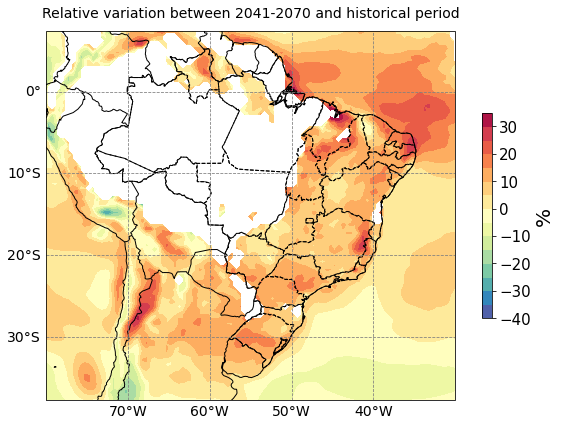

In [ ]:
#Criando um objeto de figura para receber o mapa
fig = plt.figure(figsize=(8, 8))

#Criando um eixo com uma determinada projeção
ax = fig.add_subplot(111, projection=ccrs.PlateCarree())

#Definindo a extensão do mapa
ax.set_extent([-80, -30, -35, 7])

#Criando matrizes de longitude e latitude
lon, lat = np.meshgrid(div_2.lon, div_2.lat)

#Plotando a temperatura do ar para o globo todo
im = ax.contourf(lon, lat, div_2, cmap='Spectral_r', levels=np.arange(-40, 40, 5), transform=ccrs.PlateCarree())


#Inserindo uma colorbar
cbar = fig.colorbar(im, ax=ax, pad=0.06, fraction=0.023)
cbar.set_label(label='%', size=20, weight='normal')
cbar.ax.tick_params(labelsize=15)

#Adicionando o contorno dos continentes
ax.add_feature(cfeature.COASTLINE)

#Adicionando os limites dos países
ax.add_feature(cfeature.BORDERS)

#Adicionando os limites estaduais
states = cfeature.NaturalEarthFeature(category='cultural',
                                      name='admin_1_states_provinces_shp',
                                      scale='50m',
                                      facecolor='none')
ax.add_feature(states, edgecolor='k', linestyle='--')

#Adicionando o título da figura
ax.set_title('Relative variation between 2041-2070 and historical period', fontsize=14, y=1.02)

#Adicionando as linhas de grade
g1 = ax.gridlines(crs=ccrs.PlateCarree(), linestyle='--', color='gray', draw_labels=True)

#Removendo os labels do topo e da direita
g1.ylabels_right = False
g1.xlabels_top = False

#Formatando os labels como latitude e longitude
g1.yformatter = LATITUDE_FORMATTER
g1.xformatter = LONGITUDE_FORMATTER

#Mofificando o tamanho da fonte dos labels
g1.xlabel_style = {'size': 14}
g1.ylabel_style = {'size': 14}

#plt.savefig('RV_26_1.png', dpi=300, bbox_inches='tight')

# plot seasonal relative difference

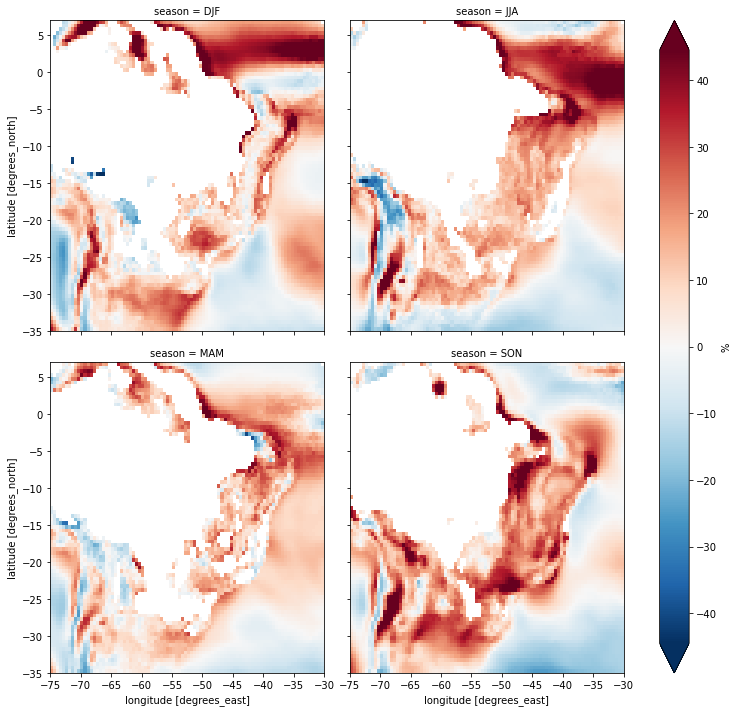

In [ ]:
#season = w_season.sel(time=slice('1961-01','2005-12')).groupby('time.season').mean(dim='time')
x = w_anual.sel(time=slice('2071-01','2099-12')).sel(lon=slice(-75, -30), lat=slice(-35, 7)).groupby('time.season').mean(dim='time')
y = w_anual.sel(time=slice('1971-01','1999-12')).sel(lon=slice(-75, -30), lat=slice(-35, 7)).groupby('time.season').mean(dim='time')
div =  ((x-y)/y)*100
div.plot.imshow(col='season', col_wrap=2, cbar_kwargs={"label": "%"}, robust=True, size = 5, extend='both')
plt.savefig('RV_seasonal_85.png', dpi=300, bbox_inches='tight')

# Man-Kendal test [https://pypi.org/project/pymannkendall/]

In [ ]:
import pymannkendall as mk

In [ ]:
br_mktest = w_anual.sel(time=slice('2006-01','2099-12')).sel(lon=slice(-75, -30), lat=slice(-35, 7)).mean(dim=('lat','lon'))
result = mk.original_test(br_mktest)
print(result)

Mann_Kendall_Test(trend='decreasing', h=True, p=0.03160349941604146, z=-2.1493899756116304, Tau=-0.04273254167531953, s=-27162.0, var_s=159683878.66666666, slope=-0.05755865635016026, intercept=2589.9445567595653)


In [ ]:
ne_mktest = w_anual.sel(time=slice('2006-01','2099-12')).sel(lon=slice(-40., -35.), lat=slice(-8., -2.)).mean(dim=('lat','lon'))
result = mk.original_test(ne_mktest)
print(result)

Mann_Kendall_Test(trend='increasing', h=True, p=0.0004828438259592005, z=3.490097790744072, Tau=0.06938649650424462, s=44104.0, var_s=159683878.66666666, slope=0.4364021084064239, intercept=2749.0444431629803)


In [ ]:
rs_mktest = w_anual.sel(time=slice('2006-01','2099-12')).sel(lon=slice(-57., -49.), lat=slice(-33., -27.)).mean(dim=('lat','lon'))
result = mk.original_test(rs_mktest)
print(result)

Mann_Kendall_Test(trend='no trend', h=False, p=0.10802017641565587, z=-1.6071558858177757, Tau=-0.03195265155090713, s=-20310.0, var_s=159683878.66666666, slope=-0.04447192201685393, intercept=1368.6804114549348)


trend: tells the trend (increasing, decreasing or no trend)
h: True (if trend is present) or False (if the trend is absence)
p: p-value of the significance test
z: normalized test statistics
Tau: Kendall Tau
s: Mann-Kendal's score
var_s: Variance S
slope: Theil-Sen estimator/slope
intercept: intercept of Kendall-Theil Robust Line, for seasonal test, full period cycle consider as unit time step